## Reading the data
You might get a `DtypeWarning`; ignore it now, if necessary, deal with it later.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Loading the raw dataset
df = pd.read_csv('LendingClub_wi3435TU.csv')

C:\Users\ddani\AppData\Local\Temp\ipykernel_1368\2622085447.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('LendingClub_wi3435TU.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217452 entries, 0 to 217451
Columns: 124 entries, id to settlement_term
dtypes: float64(88), int64(1), object(35)
memory usage: 205.7+ MB


#### Loading the data dictionary
The field descriptions are read in as a Pandas data frame and then extended to a (Pandas) data frame `preview` for a first peek at the data.

In [4]:
pd.set_option('max_colwidth', 1200) # controls output width; might need adjustment
data_dictionary = pd.read_csv('LCDataDictionary.csv') # Loading in the data dictionary
data_dictionary = data_dictionary.rename(columns={'LoanStatNew': 'name', 'Description': 'description'})
data_dictionary.head()

,name,description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.


In [5]:
# generate preview names + dtypes + first values + descriptions
df_dtypes = pd.DataFrame(df.dtypes,columns=['dtypes'])
df_dtypes = df_dtypes.reset_index()
df_dtypes['name'] = df_dtypes['index']
df_dtypes = df_dtypes[['name','dtypes']]
df_dtypes['first value'] = df.loc[0].values
preview = df_dtypes.merge(data_dictionary, on='name',how='left')

In [6]:
preview[0:130]

,name,dtypes,first value,description
0,id,int64,92807938,A unique LC assigned ID for the loan listing.
1,member_id,float64,NaN,A unique LC assigned Id for the borrower member.
2,loan_amnt,float64,7200.0,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
3,term,object,36 months,The number of payments on the loan. Values are in months and can be either 36 or 60.
4,int_rate,float64,11.49,Interest Rate on the loan
...,...,...,...,...
119,settlement_status,object,NaN,NaN
120,settlement_date,object,NaN,NaN
121,settlement_amount,float64,NaN,NaN
122,settlement_percentage,float64,NaN,NaN


## Features with a lot of missing values
A global investigation into the missing values, using `plt.hist` from Matplotlib.

In [7]:
# Overall fraction of null values in the data
(df.isnull().sum().sum())/(df.shape[0]*df.shape[1])

0.31231605135846074

Number of fields with more than 25% NAs: 39
Number of fields with more than 10% NAs: 40
Number of fields with less than 1%% NAs: 74


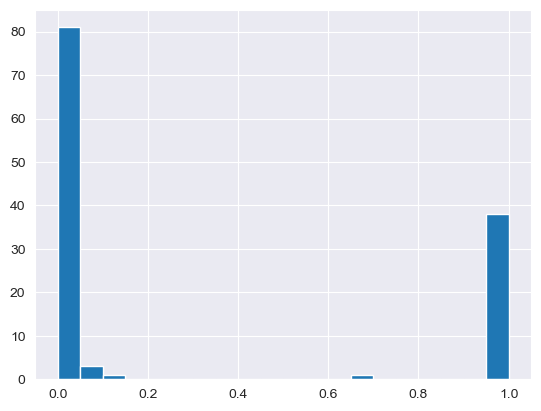

In [8]:
# create overview of distribution of NAs over the variables:
nullfrac= df.isnull().sum()/df.shape[0]
plt.hist(nullfrac,bins=20)
print("Number of fields with more than 25% NAs:", sum(nullfrac>0.25))
print("Number of fields with more than 10% NAs:", sum(nullfrac>0.10))
print("Number of fields with less than 1%% NAs:", sum(nullfrac<0.001))

In [9]:
nullfrac_is_more_than_25_percent = pd.DataFrame(nullfrac>0.25)  # which features have >25% (True) null cells and which don't (False)
#print(nullfrac_is_more_than_25_percent.head())

drop_list = nullfrac_is_more_than_25_percent.index[nullfrac_is_more_than_25_percent[0] == True].tolist() # keep only true values
print("Dropping " + str(len(drop_list))+ " features")

df.drop(drop_list, axis=1, inplace=True)

Dropping 39 features


In [10]:
df.shape

(217452, 85)

## Filtering on loan_status

In [11]:
df['loan_status'].value_counts()

Fully Paid            112409
Current                67079
Charged Off            34358
Late (31-120 days)      2252
In Grace Period          885
Late (16-30 days)        461
Default                    8
Name: loan_status, dtype: int64

In [12]:
# value counts, this time fancy in a Pandas data frame
meaning = [
"Loan has been fully paid off.",
"Loan is up to date on current payments.",
"Loan for which there is no longer a reasonable expectation of further payments.",
"Loan hasn't been paid in 31 to 120 days (late on the current payment).",
"The loan is past due but still in the grace period of 15 days.",
"Loan hasn't been paid in 16 to 30 days (late on the current payment).",
"Loan is defaulted on and no payment has been made for more than 121 days."]
status, count = df["loan_status"].value_counts().index, df["loan_status"].value_counts().values
loan_statuses_explanation = pd.DataFrame({'Loan Status': status,'Count': count,'Meaning': meaning})[['Loan Status','Count','Meaning']]
loan_statuses_explanation

,Loan Status,Count,Meaning
0,Fully Paid,112409,Loan has been fully paid off.
1,Current,67079,Loan is up to date on current payments.
2,Charged Off,34358,Loan for which there is no longer a reasonable expectation of further payments.
3,Late (31-120 days),2252,Loan hasn't been paid in 31 to 120 days (late on the current payment).
4,In Grace Period,885,The loan is past due but still in the grace period of 15 days.
5,Late (16-30 days),461,Loan hasn't been paid in 16 to 30 days (late on the current payment).
6,Default,8,Loan is defaulted on and no payment has been made for more than 121 days.


In [13]:
df = df[(df["loan_status"] == "Fully Paid") | (df["loan_status"] == "Charged Off") | (df["loan_status"] == "Default")] # added 'Default'
mapping_dictionary = {"loan_status":{ "Fully Paid": 1, "Charged Off": 0, "Default": 0}}
df = df.replace(mapping_dictionary)
df.shape

(146775, 85)

In [14]:
# The remaining features:
preview[preview["name"].isin(df.columns)]

,name,dtypes,first value,description
0,id,int64,92807938,A unique LC assigned ID for the loan listing.
2,loan_amnt,float64,7200.0,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
3,term,object,36 months,The number of payments on the loan. Values are in months and can be either 36 or 60.
4,int_rate,float64,11.49,Interest Rate on the loan
5,installment,float64,237.4,The monthly payment owed by the borrower if the loan originates.
...,...,...,...,...
86,total_bal_ex_mort,float64,86742.0,Total credit balance excluding mortgage
87,total_bc_limit,float64,10500.0,Total bankcard high credit/credit limit
101,hardship_flag,object,N,NaN
116,disbursement_method,object,Cash,NaN


## Preventing leakage

In [15]:
# collect list of features that are not available at the application date
drop_list1 = ["out_prncp", "last_pymnt_d", "last_pymnt_amnt", "last_credit_pull_d"]
df.drop(drop_list1, axis=1, inplace=True)

df.shape

(146775, 81)

In [16]:
# The remaining features:
preview[preview["name"].isin(df.columns)]

,name,dtypes,first value,description
0,id,int64,92807938,A unique LC assigned ID for the loan listing.
2,loan_amnt,float64,7200.0,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
3,term,object,36 months,The number of payments on the loan. Values are in months and can be either 36 or 60.
4,int_rate,float64,11.49,Interest Rate on the loan
5,installment,float64,237.4,The monthly payment owed by the borrower if the loan originates.
...,...,...,...,...
86,total_bal_ex_mort,float64,86742.0,Total credit balance excluding mortgage
87,total_bc_limit,float64,10500.0,Total bankcard high credit/credit limit
101,hardship_flag,object,N,NaN
116,disbursement_method,object,Cash,NaN


## Dropping features of no/little predictive value

In [17]:
drop_list2 = ['id','disbursement_method', 'url', 'initial_list_status']
df.drop(drop_list2, axis=1, inplace=True)

df.shape

(146775, 77)

## Unbalanced features

In [18]:
# Looking at value-counts:
for col in df.columns[0:77]:
    print(df[col].value_counts(sort=True, normalize=True))
    print()

10000.0    0.074311
20000.0    0.053197
12000.0    0.052107
15000.0    0.051249
5000.0     0.041949
             ...   
37700.0    0.000007
38475.0    0.000007
35150.0    0.000007
28425.0    0.000007
36175.0    0.000007
Name: loan_amnt, Length: 1450, dtype: float64

 36 months    0.791415
 60 months    0.208585
Name: term, dtype: float64

5.32     0.045921
11.99    0.037356
11.49    0.034243
13.99    0.031484
11.47    0.029903
           ...   
17.86    0.000014
21.99    0.000007
14.77    0.000007
27.31    0.000007
18.20    0.000007
Name: int_rate, Length: 137, dtype: float64

301.15     0.004476
602.30     0.003359
451.73     0.003168
329.72     0.002909
329.62     0.002882
             ...   
520.19     0.000007
386.65     0.000007
99.94      0.000007
1049.79    0.000007
555.64     0.000007
Name: installment, Length: 25194, dtype: float64

B    0.303505
C    0.295486
A    0.167338
D    0.139002
E    0.063798
F    0.023941
G    0.006929
Name: grade, dtype: float64

B5    0.070686
C1  

In [19]:
drop_list3 = ['application_type', 'hardship_flag', 'debt_settlement_flag', 'acc_now_delinq', 'collections_12_mths_ex_med',
              'chargeoff_within_12_mths']
df.drop(drop_list3, axis=1, inplace=True)

df.shape

(146775, 71)

## Highly correlated features

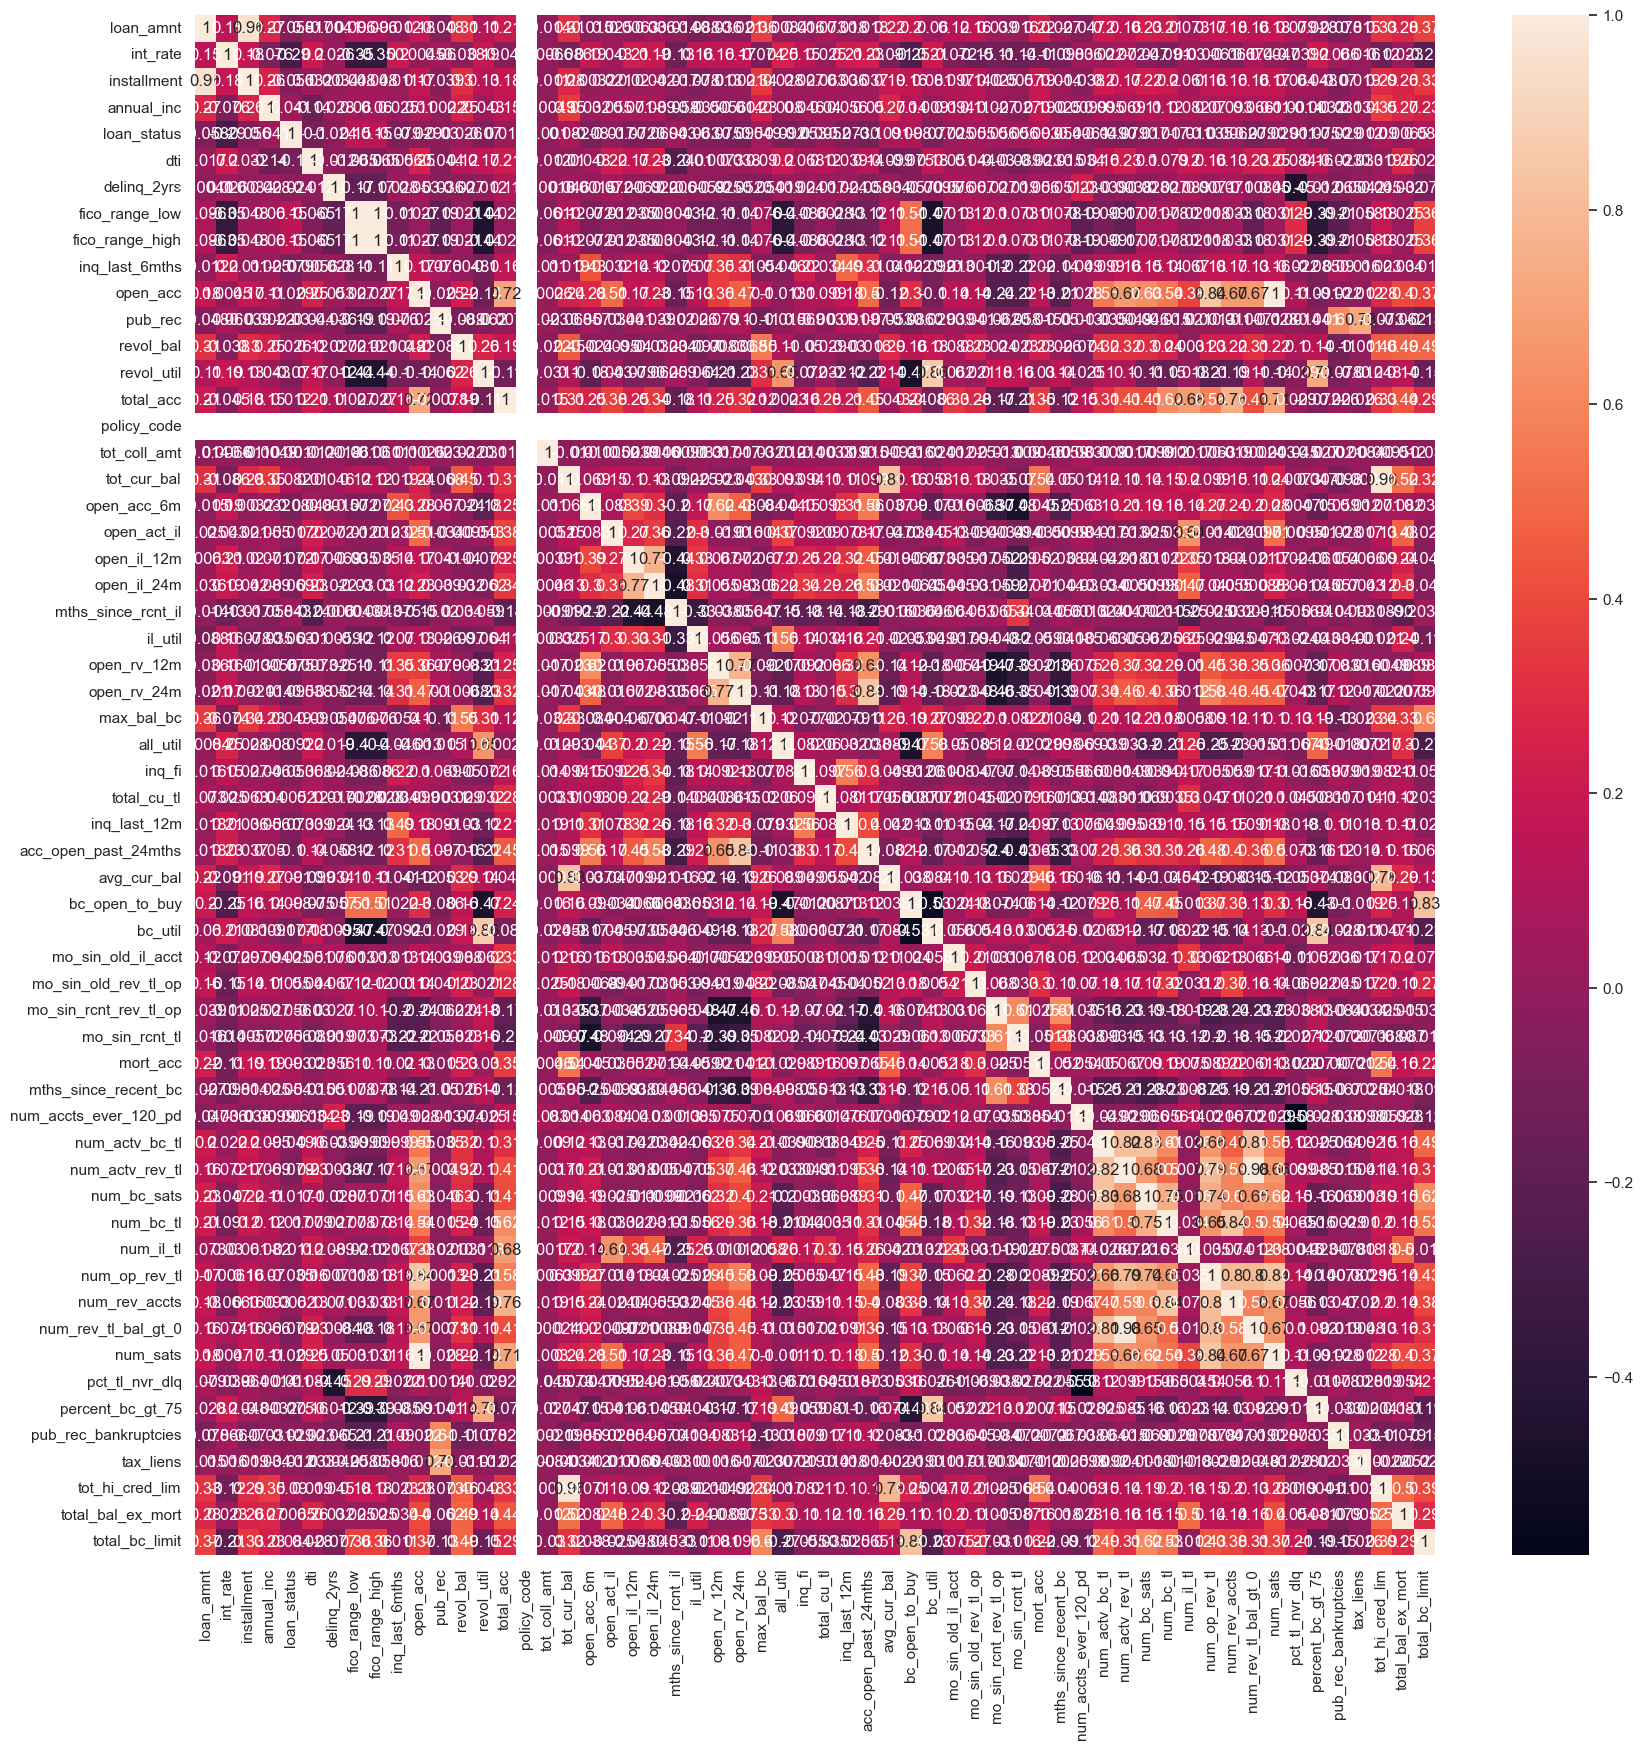

In [20]:
# Checking correlation and using heatmap to visualise it.
# First select a subset of the columns to keep the size of the correlation matrix low
# Output looks a bit strange, is it OK?
select = list(df.columns[0:71])
dfsel = pd.DataFrame(df[select])
sns.set(rc={'figure.figsize':(20,20)})
sns.set_style('whitegrid')
# Compute correlations and plot heatmap (exclude non-numeric features)
correlations = dfsel.corr() # excluding non-numeric features happens by default
sns.heatmap(correlations,annot=True)
plt.show()

In [21]:
drop_list4 =['installment', 'fico_range_high', 'open_acc', 'revol_util', 'total_acc', 'tot_cur_bal', 'open_il_24m',
             'open_rv_24m', 'bc_util', 'total_bc_limit', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl','num_rev_tl_bal_gt_0']
df.drop(drop_list4, axis=1, inplace=True)

df.shape

(146775, 57)

## Getting rid of the remaining missing values
Upon first running, before (many) features have been dropped, the list below might/will still contain a large number of feature, many with a large number of missing values. This might indicate you have not cleaned enough in the earlier stages.

In [22]:
# Create dataframe of null-counts and look at the numbers
NAcount= df.isnull().sum()
hasNAs = NAcount[NAcount>0]
print("There are", len(hasNAs), "features that have missing values.")
b = pd.DataFrame(hasNAs,columns=['Number of null values'])
b.sort_values(by=['Number of null values'],ascending=False)

There are 20 features that have missing values.


,Number of null values
il_util,19132
emp_title,9586
emp_length,9486
title,8241
mths_since_rcnt_il,3760
mo_sin_old_il_acct,3730
percent_bc_gt_75,1644
bc_open_to_buy,1636
mths_since_recent_bc,1539
all_util,40


In [23]:
# Dropping features il_util & title:
drop_list4 =['il_util', 'title']
df.drop(drop_list4, axis=1, inplace=True)

In [24]:
# Looking at null-counts again:
NAcount= df.isnull().sum()
hasNAs = NAcount[NAcount>0]
print("There are", len(hasNAs), "features that have missing values.")
b = pd.DataFrame(hasNAs,columns=['Number of null values'])
b.sort_values(by=['Number of null values'],ascending=False)

There are 18 features that have missing values.


,Number of null values
emp_title,9586
emp_length,9486
mths_since_rcnt_il,3760
mo_sin_old_il_acct,3730
percent_bc_gt_75,1644
bc_open_to_buy,1636
mths_since_recent_bc,1539
all_util,40
open_acc_6m,33
total_cu_tl,33


In [25]:
# Emp title has the same instances of missing values as emp_length (along with other 78 different instances) so we can drop all their missing values.
# In other cases, we have smaller amounts of missing values:
df = df.dropna(subset=['emp_title','emp_length','all_util','total_cu_tl','inq_last_12m','open_acc_6m','open_rv_12m','max_bal_bc','inq_fi','open_il_12m',
                       'open_act_il','dti','inq_last_6mths','mo_sin_old_il_acct','bc_open_to_buy','percent_bc_gt_75','mths_since_recent_bc'])

# There should be no null counts after this:
NAcount= df.isnull().sum()
hasNAs = NAcount[NAcount>0]
print("There are", len(hasNAs), "features that have missing values.")
b = pd.DataFrame(hasNAs,columns=['Number of null values'])
b.sort_values(by=['Number of null values'],ascending=False)

There are 0 features that have missing values.


,Number of null values


In [26]:
df.shape # check dimensions

(132460, 55)

## Dates
There may or may not be any date features left. Let's check the categorical features still present.

In [27]:
print("Data types and their frequency\n{}".format(df.dtypes.value_counts()))

Data types and their frequency
float64    42
object     12
int64       1
dtype: int64


In [28]:
# generate list of remaining categorical features
obcols = list(df.columns[df.dtypes == 'object'])
preview[preview["name"].isin(obcols)]

,name,dtypes,first value,description
3,term,object,36 months,The number of payments on the loan. Values are in months and can be either 36 or 60.
6,grade,object,B,LC assigned loan grade
7,sub_grade,object,B5,LC assigned loan subgrade
8,emp_title,object,Health Information Specialist,The job title supplied by the Borrower when applying for the loan.*
9,emp_length,object,7 years,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
10,home_ownership,object,RENT,"The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER."
12,verification_status,object,Not Verified,"Indicates if income was verified by LC, not verified, or if the income source was verified"
13,issue_d,object,Dec-2016,The month which the loan was funded
17,purpose,object,debt_consolidation,A category provided by the borrower for the loan request.
19,zip_code,object,100xx,The first 3 numbers of the zip code provided by the borrower in the loan application.


In [29]:
# Since all issue_d values span accross january 2016-december 2016, they are not relevant for prediction:
df.drop(['issue_d'], axis=1, inplace=True)
df.shape

(132460, 54)

In [30]:
# Inspecting feature earliest_cr_line
print(df['earliest_cr_line'])
print()

preview[preview["name"] == 'earliest_cr_line']

0         Dec-2004
1         Jun-2011
2         Aug-2008
3         Mar-1997
4         Jun-1999
            ...   
217445    Nov-2003
217446    Oct-2002
217448    Apr-2000
217449    Sep-2004
217450    Feb-1988
Name: earliest_cr_line, Length: 132460, dtype: object



,name,dtypes,first value,description
23,earliest_cr_line,object,Dec-2004,The month the borrower's earliest reported credit line was opened


In [31]:
# Recoding feature "earliest_cr_line" to float:
dates = pd.DataFrame(pd.to_datetime(df['earliest_cr_line'], format='%m%Y', errors='ignore').astype('datetime64').astype(np.int64).astype(float))
df['earliest_cr_line'] = dates['earliest_cr_line']

In [32]:
# The changes done:
df['earliest_cr_line']

0         1.101859e+18
1         1.306886e+18
2         1.217549e+18
3         8.571744e+17
4         9.281952e+17
              ...     
217445    1.067645e+18
217446    1.033430e+18
217448    9.545472e+17
217449    1.093997e+18
217450    5.706720e+17
Name: earliest_cr_line, Length: 132460, dtype: float64

In [33]:
df.shape

(132460, 54)

## Export the processed data

In [34]:
df.to_csv('LendingClub_processed.csv', index=False)